In [125]:
import os
import anndata
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.decomposition import TruncatedSVD
from scipy import sparse, io

# Scanpy analysis
More information:
https://www.kallistobus.tools/tutorials/kb_getting_started/python/kb_intro_2_python/

In [221]:
# Read in .h5ad count matrix generated with Kallisto-Bustools-countmatrix.ipynb output_dir/counts_unfiltered/
# or alternatively /gpfs/space/projects/genomic_references/OneK1K/fastq/onepoolh5ad/
adata = anndata.read("/gpfs/space/projects/genomic_references/OneK1K/fastq/onepoolh5ad/adata.h5ad")
adata

AnnData object with n_obs × n_vars = 716653 × 60623
    var: 'gene_name'

### Preprocessing

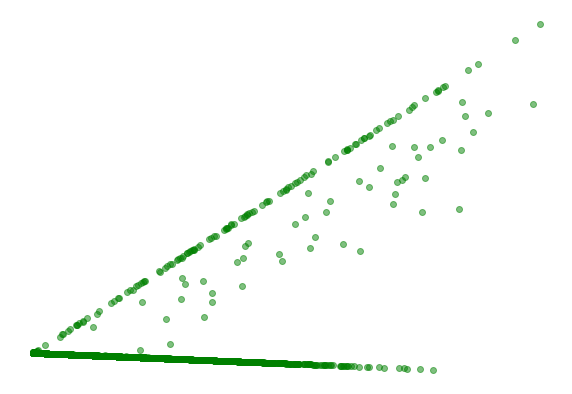

In [222]:
# Perform SVD
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(adata.X)
X = tsvd.transform(adata.X)

# Plot the cells in the 2D PCA projection
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(X[:,0], X[:,1], alpha=0.5, c="green")

plt.axis('off')
plt.show()

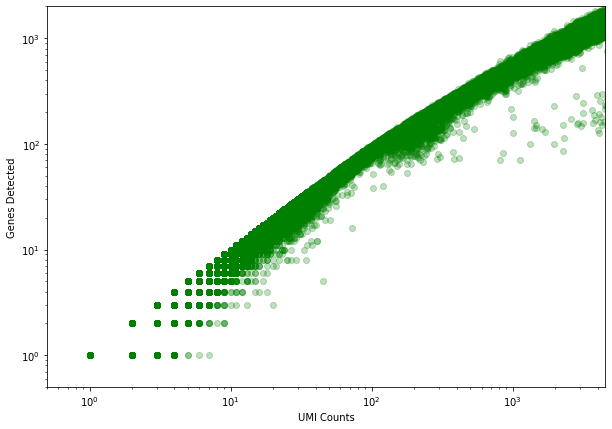

In [223]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(adata.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((0.5, 4500))
ax.set_ylim((0.5,2000))


plt.show()

### Filtering

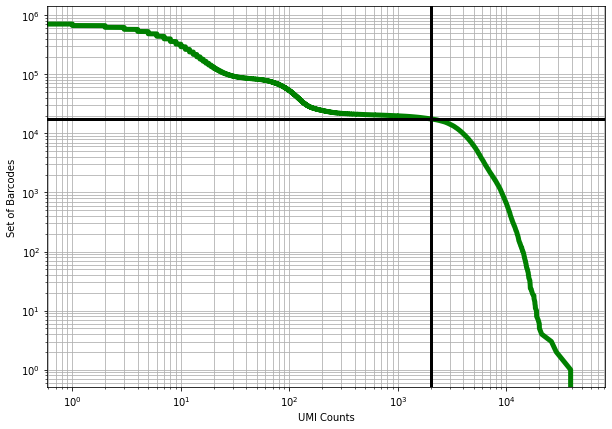

In [224]:
cutoff =  2000#@param {type:"integer"}
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [225]:
print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")

17,578 cells passed the 2000 UMI threshold


In [226]:
adata

AnnData object with n_obs × n_vars = 716653 × 60623
    var: 'gene_name'

In [227]:
# Filter the cells according to the threshold determined from the knee plot
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_cells(adata, min_counts=knee[num_cells])

In [228]:
mito_ensembl_ids = sc.queries.mitochondrial_genes("hsapiens", attrname="ensembl_gene_id").values.tolist()
mito_ensembl_ids = [item for sublist in mito_ensembl_ids for item in sublist]

In [229]:
# Count matrix ensembl_ids have .<num> suffixes, ignore them in order to find suffixless mito ensembl ids 
correct_names = []
for i in mito_ensembl_ids:
    for j in adata.var.index.tolist():
        if (j.startswith(i)):
            correct_names.append(j)

In [230]:
# Copy that won't have dead cells and doublets removed, in order to plot alternative UMAP
adata_nofilter = adata.copy()

In [231]:
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, correct_names].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

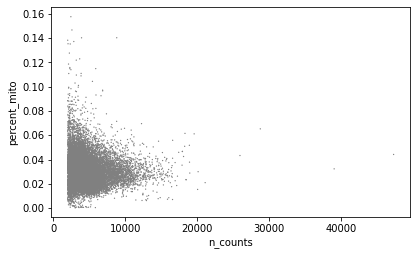

In [232]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')

### Filtering out dead and doublet cells

In [233]:
adata = adata[adata.obs.percent_mito < 0.06]

In [234]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_genes(adata_nofilter, min_cells=3)

/gpfs/space/home/ingvar/BioENV/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [235]:
sc.external.pp.scrublet(adata)

/gpfs/space/home/ingvar/BioENV/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.16
Detected doublet rate = 10.7%
Estimated detectable doublet fraction = 62.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 17.0%


In [236]:
# Remove doublets
adata = adata[adata.obs['predicted_doublet'] == False]

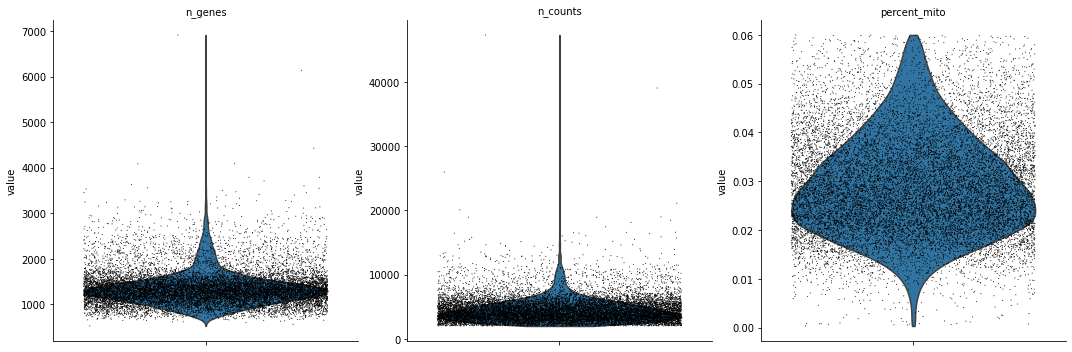

In [237]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)

In [238]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

sc.pp.normalize_per_cell(adata_nofilter, counts_per_cell_after=1e4)
sc.pp.log1p(adata_nofilter)

/gpfs/space/home/ingvar/BioENV/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


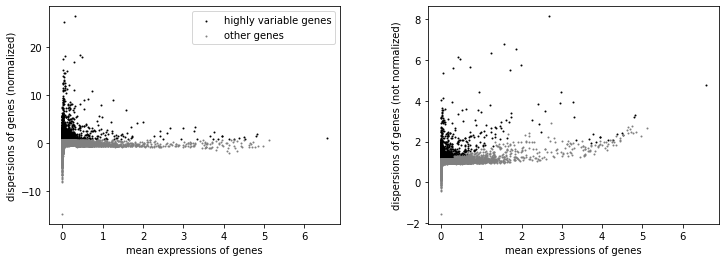

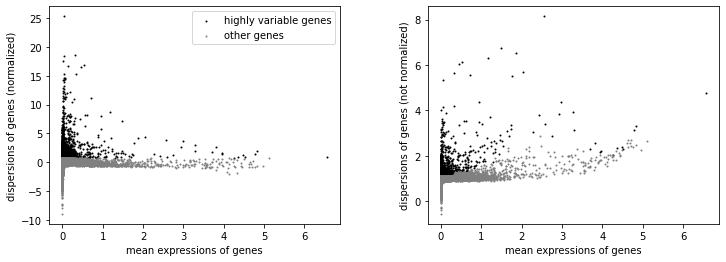

In [239]:
# flavor="cell_ranger" is consistent with Seurat and flavor="suerat" is not consistent with Seurat
sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=8, min_disp=1, n_top_genes=3000, n_bins=20, flavor="seurat")
sc.pl.highly_variable_genes(adata)

sc.pp.highly_variable_genes(adata_nofilter, min_mean=0.01, max_mean=8, min_disp=1, n_top_genes=3000, n_bins=20, flavor="seurat")
sc.pl.highly_variable_genes(adata_nofilter)

In [240]:
sc.pp.scale(adata, max_value=10)
sc.pp.scale(adata_nofilter, max_value=10)

In [241]:
adata

AnnData object with n_obs × n_vars = 15275 × 32261
    obs: 'n_genes', 'n_counts', 'percent_mito', 'doublet_score', 'predicted_doublet'
    var: 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'scrublet', 'log1p', 'hvg'

### UMAP without dead cells and doublets removed

In [242]:
sc.tl.pca(adata_nofilter, n_comps=10)
sc.pp.neighbors(adata_nofilter, n_neighbors=30, n_pcs=10, knn=True)
sc.tl.umap(adata_nofilter)

In [243]:
sc.tl.louvain(adata_nofilter)

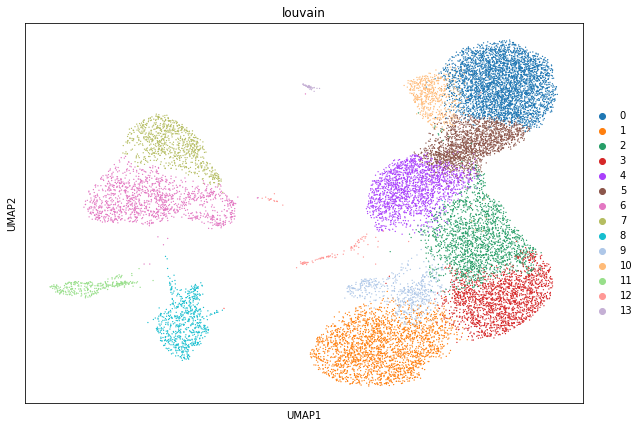

In [244]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.umap(adata_nofilter, color='louvain', ax=ax)

### UMAP with dead cells and doublets removed

In [245]:
sc.tl.pca(adata, n_comps=10)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=10, knn=True)
sc.tl.umap(adata)

In [246]:
sc.tl.louvain(adata)

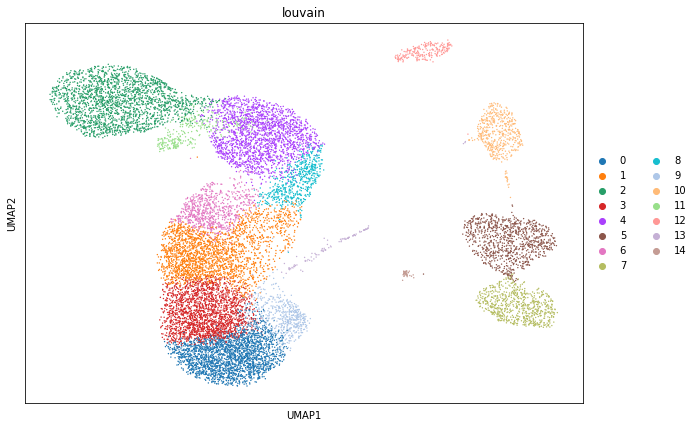

In [247]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.umap(adata, color='louvain', ax=ax)

In [249]:
# Write to disk to use in scanorama ipynb
adata.write("../data/adata.h5ad")
adata_nofilter.write("../data/adata_nofilter.h5ad")